In [94]:
import pandas as pd
import numpy as np

In [95]:
train = pd.read_csv('data/train.csv', encoding='euc-kr')
test = pd.read_csv('data/train.csv', encoding='euc-kr')
sub = pd.read_csv('data/sample_submission.csv')

- train 데이터 : 60개 건물들의 2020년 6월 1일 부터 2020년 8월 24일까지의 데이터
- 1시간 단위로 제공

- test 데이터 : 60개 건물들의 2020년 8월 25일 부터 2020년 8월 31일까지의 데이터
- 3시간 단위로 제공(강수량의 경우 6시간 단위로 제공, 예보데이터)

## 지금은 연습중이니까 일단 하나의 건물만 이용해보자
- 하지만 다른 data들이 있기때문에 multivariate

In [96]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [97]:
data = train.loc[train['num']==1,:]

In [98]:
data.shape

(2040, 10)

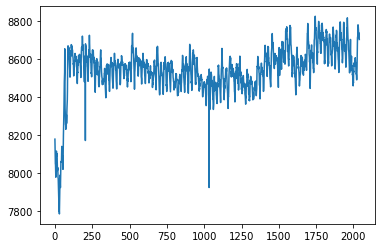

In [99]:
data['전력사용량(kWh)'].plot()

# 0. data preprocessing
- scaling
- make dataset

## scaling

In [100]:
data.columns

Index(['num', 'date_time', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)',
       '강수량(mm)', '일조(hr)', '비전기냉방설비운영', '태양광보유'],
      dtype='object')

In [101]:
del_cols = ['num','date_time', '비전기냉방설비운영', '태양광보유']
data.drop(del_cols, axis=1, inplace=True)

C:\Users\ghktj\anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [102]:
data.head()

,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr)
0,8179.056,17.6,2.5,92.0,0.8,0.0
1,8135.640,17.7,2.9,91.0,0.3,0.0
2,8107.128,17.5,3.2,91.0,0.0,0.0
3,8048.808,17.1,3.2,91.0,0.0,0.0
4,8043.624,17.0,3.3,92.0,0.0,0.0


In [103]:
col_mean = np.mean(data, axis=0)
col_std = np.std(data, axis=0)

scaled_data = (data - col_mean) / col_std

In [104]:
scaled_data.head()

,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr)
0,-2.796655,-2.145309,0.138638,1.021512,0.132597,-0.53753
1,-3.130026,-2.114699,0.498690,0.957781,-0.083975,-0.53753
2,-3.348956,-2.175919,0.768729,0.957781,-0.213918,-0.53753
3,-3.796768,-2.298358,0.768729,0.957781,-0.213918,-0.53753
4,-3.836574,-2.328968,0.858742,1.021512,-0.213918,-0.53753


## make dataset
- split train, val

In [105]:
from load_data.dataset import split_multivariate_sequence, MultivariateCnnDataset

In [106]:
X, y = split_multivariate_sequence(data=np.array(scaled_data), time_seq=24, target_col_idx=0)
nums_train_idx = int(X.shape[0] * 0.9)
train_X, train_y = X[:nums_train_idx], y[:nums_train_idx]
valid_X, valid_y = X[nums_train_idx:], y[nums_train_idx:]

In [107]:
dataset_train = MultivariateCnnDataset(train_X, train_y)
dataset_val = MultivariateCnnDataset(valid_X, valid_y)

In [108]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
            dataset_train,
            shuffle=False,
            batch_size=128,
            num_workers=4,
            pin_memory=1,
        )

valid_loader = DataLoader(
            dataset_val,
            shuffle=False,
            batch_size=128,
            num_workers=4,
            pin_memory=1,
        )

In [109]:
from argparse import Namespace

config = {
    'batch_size': 256,
    'num_workers':4,
    'gpus':1,
    'n_epochs': 5,
    'in_channels':[6, 8, 16, 8],
    'out_channels':[8, 16, 8, 4],
    'kernel_size':[3, 3, 3, 4],
    'num_layers':4,

    }

config = Namespace(**config)

In [110]:
from models.DilatedCNN import CNNForecasting
import torch
from copy import deepcopy

In [111]:
crit = torch.nn.MSELoss()
model = CNNForecasting(config)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters())

In [112]:
model.train()
nums_epochs = 100
lowest_val_loss = int(1e9)

for epoch in range(nums_epochs):
    total_loss = 0
    val_total_loss = 0  
    for x_i, y_i in train_loader:
        x_i = x_i.cuda()
        y_i = y_i.cuda()
        y_hat_i = model(x_i)
        loss_i = crit(y_hat_i, y_i)

        optimizer.zero_grad()
        loss_i.backward()
        optimizer.step()
        
        total_loss += float(loss_i)
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1} : train loss {total_loss:.3f}')

    model.eval()
    with torch.no_grad():
        for x_i, y_i in valid_loader:
            x_i = x_i.cuda()
            y_i = y_i.cuda()
            val_y_hat_i = model(x_i)
            val_loss_i = crit(val_y_hat_i, y_i)
            val_total_loss += float(val_loss_i)
        if val_total_loss < lowest_val_loss:
            # 모델 저장
            best_model = deepcopy(model)
            torch.save({
                'model' : best_model.state_dict(),
                'config' : config,
            }, './logs/CNN.pt')
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1} : val loss {val_total_loss:.3f}')
        print(f'-----------------------------------------------')

    

Epoch 1 : train loss 1489.126
Epoch 1 : val loss 86.683
-----------------------------------------------
Epoch 11 : train loss 59.866
Epoch 11 : val loss 17.281
-----------------------------------------------
Epoch 21 : train loss 30.997
Epoch 21 : val loss 11.222
-----------------------------------------------
Epoch 31 : train loss 21.243
Epoch 31 : val loss 8.411
-----------------------------------------------
Epoch 41 : train loss 16.316
Epoch 41 : val loss 6.787
-----------------------------------------------
Epoch 51 : train loss 13.169
Epoch 51 : val loss 5.752
-----------------------------------------------
Epoch 61 : train loss 10.874
Epoch 61 : val loss 4.966
-----------------------------------------------
Epoch 71 : train loss 9.140
Epoch 71 : val loss 4.378
-----------------------------------------------
Epoch 81 : train loss 7.824
Epoch 81 : val loss 3.916
-----------------------------------------------
Epoch 91 : train loss 6.837
Epoch 91 : val loss 3.579
------------------

In [113]:
model = model.cpu()
checkpoint = torch.load('./logs/CNN.pt')
model.load_state_dict(checkpoint['model'])  # state_dict를 불러 온 후, 모델에 저장

pred = []
model.eval()
with torch.no_grad():
    for x_i, y_i in valid_loader:
        x_i = x_i
        y_i = y_i
        pred +=list(np.array(model(x_i).view(-1)))

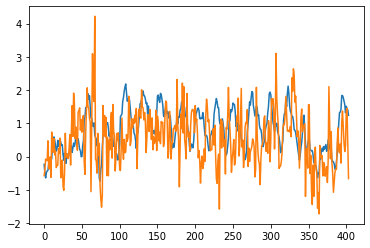

In [119]:
import matplotlib.pyplot as plt

plt.plot(valid_y.reshape(-1))
plt.plot(pred)